In [291]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer # to perform stemming
from sklearn.metrics.pairwise import cosine_similarity
import pickle

In [107]:
movies = pd.read_csv('archive/tmdb_5000_movies.csv')
credits = pd.read_csv('archive/tmdb_5000_credits.csv')

In [108]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [109]:
credits.head(1)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


### Data Pre Processing

In [110]:
credits['cast'][1]

'[{"cast_id": 4, "character": "Captain Jack Sparrow", "credit_id": "52fe4232c3a36847f800b50d", "gender": 2, "id": 85, "name": "Johnny Depp", "order": 0}, {"cast_id": 5, "character": "Will Turner", "credit_id": "52fe4232c3a36847f800b511", "gender": 2, "id": 114, "name": "Orlando Bloom", "order": 1}, {"cast_id": 6, "character": "Elizabeth Swann", "credit_id": "52fe4232c3a36847f800b515", "gender": 1, "id": 116, "name": "Keira Knightley", "order": 2}, {"cast_id": 12, "character": "William \\"Bootstrap Bill\\" Turner", "credit_id": "52fe4232c3a36847f800b52d", "gender": 2, "id": 1640, "name": "Stellan Skarsg\\u00e5rd", "order": 3}, {"cast_id": 10, "character": "Captain Sao Feng", "credit_id": "52fe4232c3a36847f800b525", "gender": 2, "id": 1619, "name": "Chow Yun-fat", "order": 4}, {"cast_id": 9, "character": "Captain Davy Jones", "credit_id": "52fe4232c3a36847f800b521", "gender": 2, "id": 2440, "name": "Bill Nighy", "order": 5}, {"cast_id": 7, "character": "Captain Hector Barbossa", "credit_

In [111]:
movies.shape

(4803, 20)

In [112]:
credits.shape

(4803, 4)

Check if both data frames have same entries or not.<br>
It's just a sanity check before proceeding to `EDA`.

In [113]:
assert movies.shape[0] == credits.shape[0], 'Number of entries should be same'

Merge `credits` and `title` data for ease of manipulation

In [114]:
movies = movies.merge(credits, on = 'title')

In [115]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [116]:
movies.shape

(4809, 23)

We are making Content based Filtering system.<br>
So some parameters will not be important for us:
- Budget
-  Homepage
-  Title (original_title can have names in regional languages so we will drop it.)
-  Production Companies
- Movie ID
- Popularity
- production Countries
- Release Data
- Revenue
- Runtime
- Spoken Language
- Status
- Tagline
- Vote Average
- Movie ID

We will remove the above mentioned columns and keep only required ones.

In [117]:
movies = movies[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']]
movies.head(2)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


We will combine `genres`, `keywords` , `crew` & `cast` column into a single column.<br>
- Out of `cast` the name of top 3 actors will be extracted.
- In the `crew` column inly the name of director will be extracted.
- In the `genre` I will extract the actual `genre` of movie.
-  In the `keyword` I will extract specific keywords from the column

In [118]:
movies.isnull().sum()

movie_id    0
title       0
overview    3
genres      0
keywords    0
cast        0
crew        0
dtype: int64

Drop the null values as they are very less as compared to the number of entries in the data set.

In [119]:
movies.dropna(inplace=True)

In [120]:
movies.duplicated().sum()

0

In [121]:
movies.iloc[0].genres

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

As in the genres column we only need the specific genre.<br>
So we will pre process the column in such a way that we only get the names of the genres present in it like : `[Action, Adventure, Fantasy, Science Fiction]`

In [122]:
import ast # for converting the string in list

def convert_genres_keywords(genres):
    gen = []
    for i in ast.literal_eval(genres):
        gen.append(i['name'])
    return gen

movies['genres'] = movies['genres'].apply(convert_genres_keywords)

In [123]:
movies.head(1)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


Same function will be applied to `keywords`

In [124]:
movies['keywords'] = movies['keywords'].apply(convert_genres_keywords)

In [125]:
movies.head(1)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


In [129]:
# For the cast column we will only keep top 3 actors
def convert_genres_keywords(cast):
    cas = []
    counter = 0
    for i in ast.literal_eval(cast):
        if counter != 3:
            cas.append(i['name'])
            counter += 1
        else:
            break
    return cas

movies['cast'] = movies['cast'].apply(convert_genres_keywords)

Preprocess `crew` column.<br>
Only extract name of director

In [139]:
def fetch_director(crew):
    cre = []
    for i in ast.literal_eval(crew):
        if(i['job'] == 'Director'):
            cre.append(i['name'])
            break
    return cre

In [141]:
movies['crew'] = movies['crew'].apply(fetch_director)

In [144]:
movies.head(1)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]


Convert the `overview` column into a list.

In [149]:
movies['overview'] = movies['overview'].apply(lambda x:x.split())

In [152]:
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weaver]",[James Cameron]
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...","[Johnny Depp, Orlando Bloom, Keira Knightley]",[Gore Verbinski]
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, based on novel, secret agent, sequel, mi...","[Daniel Craig, Christoph Waltz, Léa Seydoux]",[Sam Mendes]
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dc comics, crime fighter, terrorist, secret i...","[Christian Bale, Michael Caine, Gary Oldman]",[Christopher Nolan]
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, Science Fiction]","[based on novel, mars, medallion, space travel...","[Taylor Kitsch, Lynn Collins, Samantha Morton]",[Andrew Stanton]


Now we will remove all the whitespaces in each column.

In [154]:
movies['genres'] = movies['genres'].apply(lambda x:[i.replace(' ', '') for i in x])
movies['keywords'] = movies['keywords'].apply(lambda x:[i.replace(' ', '') for i in x])
movies['cast'] = movies['cast'].apply(lambda x:[i.replace(' ', '') for i in x])
movies['crew'] = movies['crew'].apply(lambda x:[i.replace(' ', '') for i in x])

In [156]:
movies.head(2)

,movie_id,title,overview,genres,keywords,cast,crew
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron]
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski]


Create a new column named `tag` and concatenate all column `keywords`, `cast`, `crew`, `genres`

In [157]:
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']

In [158]:
movies.head(2)

,movie_id,title,overview,genres,keywords,cast,crew,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski],"[Captain, Barbossa,, long, believed, to, be, d..."


Merge remove the `keywords, genres, cast, crew` column as we have clubed them together in `tags` column.

In [173]:
new_df = movies[['movie_id', 'title', 'tags']]

In [174]:
new_df['tags'] = new_df['tags'].apply(lambda x:(" ".join(x)).lower())

C:\Users\Aditya\AppData\Local\Temp/ipykernel_12016/905537451.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x:(" ".join(x)).lower())


Now there are some words like `actor` & `actors` which are similar so we will apply stemming to remove such similar words.

In [206]:
ps = PorterStemmer()

def stem(text):
    y = []
    for i in text.split():
        y.append(ps.stem(i))
    return ' '.join(y)

In [213]:
new_df['tags'] = new_df['tags'].apply(stem)

C:\Users\Aditya\AppData\Local\Temp/ipykernel_12016/3213734980.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(stem)


In [214]:
new_df['tags'][0]

'in the 22nd century, a parapleg marin is dispatch to the moon pandora on a uniqu mission, but becom torn between follow order and protect an alien civilization. action adventur fantasi sciencefict cultureclash futur spacewar spacecoloni societi spacetravel futurist romanc space alien tribe alienplanet cgi marin soldier battl loveaffair antiwar powerrel mindandsoul 3d samworthington zoesaldana sigourneyweav jamescameron'

In [215]:
new_df.head(3)

,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a parapleg marin is dispa..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believ to be dead, ha c..."
2,206647,Spectre,a cryptic messag from bond’ past send him on a...


### Text Vectorization

- I will treat each word in the `tags` column as a vector.
- And I will count the frequency of each word and create a vector for all such movie names.<br>
- The top `5000` most common words will be extracted and vectorization will be applied on them.
- After vectorization , if a user chooses a movie then the 5 closest vectors will be suggested for the selected movie.
- The stopwords like (in, are, am, etc) will be removed.

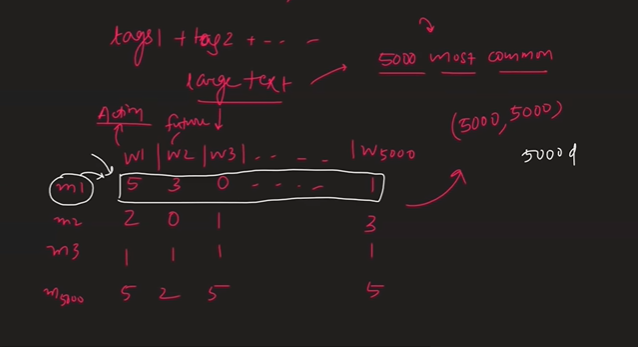

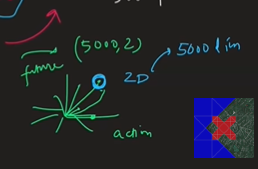

To create a `bag of words` we will use an inbuilt module named **CountVectorizer** from **sklearn.feature_extraction.text**

In [216]:
cv = CountVectorizer(max_features=5000, stop_words='english')

In [217]:
vectors = cv.fit_transform(new_df['tags']).toarray()

In [218]:
vectors[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [219]:
# we can extract the most frequently occurring 5000 words
cv.get_feature_names()

['000',
 '007',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '17th',
 '18',
 '18th',
 '18thcenturi',
 '19',
 '1910',
 '1920',
 '1930',
 '1940',
 '1944',
 '1950',
 '1950s',
 '1960',
 '1960s',
 '1970',
 '1970s',
 '1971',
 '1974',
 '1976',
 '1980',
 '1985',
 '1990',
 '1999',
 '19th',
 '19thcenturi',
 '20',
 '200',
 '2003',
 '2009',
 '20th',
 '21st',
 '23',
 '24',
 '25',
 '30',
 '300',
 '3d',
 '40',
 '50',
 '500',
 '60',
 '70',
 '80',
 'aaron',
 'aaroneckhart',
 'abandon',
 'abduct',
 'abigailbreslin',
 'abil',
 'abl',
 'aboard',
 'abov',
 'abus',
 'academ',
 'academi',
 'accept',
 'access',
 'accid',
 'accident',
 'acclaim',
 'accompani',
 'accomplish',
 'account',
 'accus',
 'ace',
 'achiev',
 'acquaint',
 'act',
 'action',
 'actionhero',
 'activ',
 'activist',
 'activities',
 'actor',
 'actress',
 'actual',
 'ad',
 'adam',
 'adamsandl',
 'adamshankman',
 'adapt',
 'add',
 'addict',
 'adjust',
 'admir',
 'admit',
 'adolesc',
 'adopt',
 'ador',
 'adrienbrodi',
 'adult'

- Now after finding vectors we will find the distance between each vectors.
- Distance will be found by `cosine similarity` as in a larger dimension Euclidian Distance fails.
- **Cosine Distance** is the angle between two vectors. The lesser the angle the more two vectors are related.

In [225]:
similarity = cosine_similarity(vectors)

In [226]:
similarity[0]

array([1.        , 0.08346223, 0.0860309 , ..., 0.04499213, 0.        ,
       0.        ])

- Every entry in the similarity array shows the distance of the selected movie with each movie.
- The diagonal of the matrix is 1 as distance of each movie with itself is 1.
- We sort the above values and extract top 5 entries.This will be the movies that we will be recommending to the user.

In [229]:
list(enumerate(similarity[0])) # preserves indices

[(0, 1.0000000000000002),
 (1, 0.08346223261119858),
 (2, 0.08603090020146065),
 (3, 0.0734718358370645),
 (4, 0.1892994097121204),
 (5, 0.10838874619051501),
 (6, 0.04024218182927669),
 (7, 0.14673479641335554),
 (8, 0.05923488777590923),
 (9, 0.0967301666813349),
 (10, 0.10259783520851541),
 (11, 0.09464970485606021),
 (12, 0.09037128496931669),
 (13, 0.04499212706658476),
 (14, 0.12824729401064427),
 (15, 0.06282808624375433),
 (16, 0.07894736842105264),
 (17, 0.13977653617040256),
 (18, 0.09493290614465533),
 (19, 0.0830812984794528),
 (20, 0.058038100008800934),
 (21, 0.10968169942141635),
 (22, 0.0662266178532522),
 (23, 0.08740748201220976),
 (24, 0.0533380747062665),
 (25, 0.05101627678885769),
 (26, 0.15389675281277312),
 (27, 0.18693292157876878),
 (28, 0.116543309349613),
 (29, 0.065033247714309),
 (30, 0.06684847767323797),
 (31, 0.15907119074394446),
 (32, 0.08520286456846099),
 (33, 0.09733285267845754),
 (34, 0.0),
 (35, 0.09933992677987831),
 (36, 0.17316974359835272),


In [230]:
# extract top 5 similar movies by sorting in reverse manner
# and extracting top 5 items
sorted(list(enumerate(similarity[0])), reverse=True, key = lambda x:x[1])

[(0, 1.0000000000000002),
 (1216, 0.28676966733820225),
 (2409, 0.26901379342448517),
 (3730, 0.2605130246476754),
 (507, 0.255608593705383),
 (539, 0.25038669783359574),
 (582, 0.24511108480187255),
 (1204, 0.24455799402225922),
 (1194, 0.2367785320221084),
 (61, 0.23179316248638276),
 (778, 0.23174488732966075),
 (4048, 0.2278389747471728),
 (1920, 0.2252817784447915),
 (2786, 0.21853668936906193),
 (172, 0.21239769762143662),
 (972, 0.2108663315950723),
 (322, 0.2105263157894737),
 (2333, 0.20443988269091456),
 (3608, 0.20437977982832192),
 (260, 0.20395079136182276),
 (151, 0.2029530274475215),
 (4192, 0.2029530274475215),
 (1444, 0.20277677641345318),
 (74, 0.2024645717996314),
 (1089, 0.2020475485519274),
 (3675, 0.1979082783981174),
 (973, 0.19767387315371682),
 (577, 0.1976738731537168),
 (47, 0.19672236884115843),
 (2971, 0.19252140716412977),
 (942, 0.19134594929397597),
 (495, 0.19088542889273336),
 (1201, 0.19088542889273336),
 (305, 0.19007487139298027),
 (4, 0.18929940971

In [238]:
new_df[new_df['title'] == 'Batman Begins']

Int64Index([119], dtype='int64')

In [240]:
ind = new_df[new_df['title'] == 'Batman Begins'].index[0]
ind

119

In [241]:
# distance of movie 119 with every other movie
similarity[ind]

array([0.0433555 , 0.04583492, 0.09449112, ..., 0.03706247, 0.09545044,
       0.06113544])

In [283]:
def recommend(movie):
    movie_index = new_df[new_df['title']==movie].index[0]
    distance = similarity[movie_index]
    movie_list = sorted(list(enumerate(distance)), reverse=True, key = lambda x:x[1])[1:6]
    
    counter = 1
    movie_name = new_df.loc[movie_index].title
    print(f'Recommended movies for {movie_name} are :-')
    
    for i in movie_list:
        print(counter, new_df.iloc[i[0]].title)
        counter += 1
    

In [284]:
recommend('Pirates of the Caribbean: At World\'s End')

Recommended movies for Pirates of the Caribbean: At World's End are :-
1 Pirates of the Caribbean: Dead Man's Chest
2 Pirates of the Caribbean: The Curse of the Black Pearl
3 Pirates of the Caribbean: On Stranger Tides
4 Life of Pi
5 20,000 Leagues Under the Sea


In [295]:
# print(f'Recommended movies for {movie_name} is:\n{recommend(movie_name)}')
recommend('Toy Story 3')

Recommended movies for Toy Story 3 are :-
1 Toy Story
2 Toy Story 2
3 Small Soldiers
4 Animals United
5 The Lego Movie


In [299]:
pickle.dump(new_df.to_dict(), open('movie_dict.pkl', 'wb'))

In [296]:
pickle.dump(similarity, open('similarity.pkl', 'wb'))